<a href="https://colab.research.google.com/github/a-woodbury/RxID/blob/master/RxID15_Data_Collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RxID**

RxID is a Deep Learning model for identifying medications from an image. It is trained on images from the NIH/NLM dataset, which is accessed through FTP.

This notebook is designed to allow a data scientist to select the drugs they would like to include in their model, collect sample images to confirm, download the images to their local directory, and sort by class (NDC).

# Setup

## Import Packages

In [1]:
import pandas as pd
import requests
from IPython.display import Image
from ftplib import FTP #needed to make the request to the server

# packages for processing images
! pip install rawpy
from PIL import Image
from PIL import ImageFile
import rawpy
import imageio
ImageFile.LOAD_TRUNCATED_IMAGES = True


import os, shutil, sys #required for moving files

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

     |████████████████████████████████| 1.6MB 2.8MB/s 


## Import Data

In [0]:
# path to directory; you may need to update
from google.colab import drive
drive.mount('/content/drive')

# Create Dataset

## Define Classes

Two paths: select your NDCs to train by their count of images (for a balanced dataset) or by specific NDCs (classes may be imbalanced and require additional manipulation)

### By **imagecount**

To create a balanced dataset for optimal training, I aimed to use NDCs that had the same number of images in the dataset

In [0]:
imagecount = 95 #for a balanced dataset, u

In [0]:
setname = 'Pill{}'.format(imagecount) # the name of the set of medications being classified

In [0]:
typdict = {'NDC':'str'}
df = pd.read_csv('/content/drive/My Drive/Project: Pill ID/Directory/directory_of_images.txt',sep='|', dtype=typdict, names=['NDC','IDK','FILE','TYPE','DRUG'])
df = df.dropna()
df.DRUG = df.DRUG.str.upper()
df[['ORIG_FOLDER','IMAGES','FILENAME']] = df.FILE.str.split('/', expand=True)
df['FILETYPE'] = df.FILENAME.str[-4:]
df = df[df.FILETYPE != '.WMV']

In [0]:
ndcs = df.NDC.value_counts()
n = ndcs[ndcs == imagecount].index
# #n100 = ndcs[ndcs <= 100].index
# ndcs50100 = list(set(n50) & set(n100))
dfn = df[df.NDC.isin(n)]
dfn

NDC  IDK  ...                             FILENAME FILETYPE
26852  00093725401    1  ...  CJH8_95CTK13Q5T739ORSM4OE1HMJY2.CR2     .CR2
26853  00093725401    1  ...  CUF2F_2_PEY!-WPZN5A_T9J-!67O1LK.CR2     .CR2
26854  00093725401    1  ...  CXMI3WSYHY0KB4T-X_P!VFVUVQNLL06.CR2     .CR2
26855  00093725401    1  ...   5CEDGLAOHO_MZXCBRD1!L48FU0C4XD.CR2     .CR2
26856  00093725401    1  ...   RWM2HZ054W9X2TD7XY55I5JPD3LIH5.JPG     .JPG
...            ...  ...  ...                                  ...      ...
92460  50419010510    1  ...  CESGSG0GFMZZL1IHAB09OIRO-IKEMIE.PNG     .PNG
92461  50419010510    1  ...   DHNVMVC1KAUEOYEHZ34B4NZ-TX!7OC.PNG     .PNG
92462  50419010510    1  ...   M_N!3YQS2L1PE-THOV7DCF3LW3GN70.PNG     .PNG
92463  50419010510    1  ...   OFOWX68GQ9S4W9R_K-67VQT1NODN65.PNG     .PNG
92464  50419010510    1  ...  BR3GJ1WDL_IW35NL65DMHU2E1K3O9SS.JPG     .JPG

[475 rows x 9 columns]

In [0]:
drugs = dfn.NDC.value_counts()
drugslist = drugs.index.tolist()
len(dfn.NDC.value_counts()),drugs

(5, 00173024255    95
 50419010510    95
 00591554405    95
 49702020218    95
 00093725401    95
 Name: NDC, dtype: int64)

In [0]:
dfn.DRUG.value_counts()

ALLOPURINOL 300MG TABS        95
GLIMEPIRIDE 1MG TAB           64
BETAPACE                      53
COMBIVIR                      53
LANOXIN TABLETS, USP          53
LANOXIN 0.125MG TABLETS       42
COMBIVIR 150/300MG TABLETS    42
BETAPACE 80MG TAB             42
GLIMEPIRIDE TABLETS USP       31
Name: DRUG, dtype: int64

In [0]:
df_a = dfn.groupby(['DRUG','NDC']).count()
df_a.reset_index(inplace=True)
drug_ndc = df_a[['DRUG','NDC']]
drug_ndc

DRUG          NDC
0      ALLOPURINOL 300MG TABS  00591554405
1                    BETAPACE  50419010510
2           BETAPACE 80MG TAB  50419010510
3                    COMBIVIR  49702020218
4  COMBIVIR 150/300MG TABLETS  49702020218
5         GLIMEPIRIDE 1MG TAB  00093725401
6     GLIMEPIRIDE TABLETS USP  00093725401
7     LANOXIN 0.125MG TABLETS  00173024255
8        LANOXIN TABLETS, USP  00173024255

**droplist**

Initial datasets included contraception pills, which often are dispensed in blister packs with different colored tabs to correspond to stages of the cycle. I determined this was not ideal for my initial modeling, so I include **droplist** to manually remove these meds easily.

In [0]:
droplist = []

df = dfn[~dfn.NDC.isin(droplist)]

proceed to **[Review Dataset](https://)**

---



### By **NDC**

If you know the NDCs you would like to train your model, you may enter them into the dloadndcs list 

In [0]:
ndcs = ['00093725401']

In [6]:
typdict = {'NDC':'str'}
df = pd.read_csv('/content/drive/My Drive/RxID/Directory/directory_of_images.txt',sep='|', dtype=typdict, names=['NDC','IDK','FILE','TYPE','DRUG'])
df = df.dropna()
df.DRUG = df.DRUG.str.upper()
df[['ORIG_FOLDER','IMAGES','FILENAME']] = df.FILE.str.split('/', expand=True)
df['FILETYPE'] = df.FILENAME.str[-4:]
df = df[df.FILETYPE != '.WMV']# will remove video files from query
df = df[df.NDC.isin(ndcs)]
df

NDC  IDK  ...                             FILENAME FILETYPE
26852  00093725401    1  ...  CJH8_95CTK13Q5T739ORSM4OE1HMJY2.CR2     .CR2
26853  00093725401    1  ...  CUF2F_2_PEY!-WPZN5A_T9J-!67O1LK.CR2     .CR2
26854  00093725401    1  ...  CXMI3WSYHY0KB4T-X_P!VFVUVQNLL06.CR2     .CR2
26855  00093725401    1  ...   5CEDGLAOHO_MZXCBRD1!L48FU0C4XD.CR2     .CR2
26856  00093725401    1  ...   RWM2HZ054W9X2TD7XY55I5JPD3LIH5.JPG     .JPG
...            ...  ...  ...                                  ...      ...
26944  00093725401    1  ...  BRV4UIUK_WV_J3573N!S3K4!0O53J-0.PNG     .PNG
26945  00093725401    1  ...  CEP2SPF02OCX25XJJF_GBA_8-4X9ELD.PNG     .PNG
26946  00093725401    1  ...   F!0QAOF74AA2VJT_YGDB82--KHABKO.PNG     .PNG
26947  00093725401    1  ...   FE!U0Z6YK_R42BWO3ZBL31EFFAVG7Y.PNG     .PNG
26948  00093725401    1  ...  CBL!T5UVX2J8M43DFX!82JK423IQHZW.JPG     .JPG

[95 rows x 9 columns]

In [11]:
df.NDC.value_counts()

00093725401    95
Name: NDC, dtype: int64

In [9]:
df.DRUG.value_counts()

GLIMEPIRIDE 1MG TAB        64
GLIMEPIRIDE TABLETS USP    31
Name: DRUG, dtype: int64

## Review Dataset

We noticed many DRUG names have variations within an NDC, likely due to different data entry. Before proceeding, we will make all the names the same for each NDC. 

In [0]:
df.DRUG[df.NDC == '00591554405'] = 'ALLOPURINOL 300MG'
df.DRUG[df.NDC == '50419010510'] = 'BETAPACE 80MG'
df.DRUG[df.NDC == '49702020218'] = 'COMBIVIR 150/300MG'
df.DRUG[df.NDC == '00093725401'] = 'GLIMEPIRIDE 1MG'
df.DRUG[df.NDC == '00173024255'] = 'LANOXIN 0.125MG'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

In [0]:
df

NDC  IDK  ...                             FILENAME FILETYPE
26852  00093725401    1  ...  CJH8_95CTK13Q5T739ORSM4OE1HMJY2.CR2     .CR2
26853  00093725401    1  ...  CUF2F_2_PEY!-WPZN5A_T9J-!67O1LK.CR2     .CR2
26854  00093725401    1  ...  CXMI3WSYHY0KB4T-X_P!VFVUVQNLL06.CR2     .CR2
26855  00093725401    1  ...   5CEDGLAOHO_MZXCBRD1!L48FU0C4XD.CR2     .CR2
26856  00093725401    1  ...   RWM2HZ054W9X2TD7XY55I5JPD3LIH5.JPG     .JPG
...            ...  ...  ...                                  ...      ...
92460  50419010510    1  ...  CESGSG0GFMZZL1IHAB09OIRO-IKEMIE.PNG     .PNG
92461  50419010510    1  ...   DHNVMVC1KAUEOYEHZ34B4NZ-TX!7OC.PNG     .PNG
92462  50419010510    1  ...   M_N!3YQS2L1PE-THOV7DCF3LW3GN70.PNG     .PNG
92463  50419010510    1  ...   OFOWX68GQ9S4W9R_K-67VQT1NODN65.PNG     .PNG
92464  50419010510    1  ...  BR3GJ1WDL_IW35NL65DMHU2E1K3O9SS.JPG     .JPG

[475 rows x 9 columns]

In [0]:
df.DRUG.value_counts()

LANOXIN 0.125MG       95
ALLOPURINOL 300MG     95
COMBIVIR 150/300MG    95
BETAPACE 80MG         95
GLIMEPIRIDE 1MG       95
Name: DRUG, dtype: int64

In [0]:
#this dataframe will display just the DRUG-NDC pairs for the model to be trained
df_a = df.groupby(['DRUG','NDC']).count()
df_a.reset_index(inplace=True)
drug_ndc = df_a[['DRUG','NDC']]
drug_ndc

DRUG          NDC
0   ALLOPURINOL 300MG  00591554405
1       BETAPACE 80MG  50419010510
2  COMBIVIR 150/300MG  49702020218
3     GLIMEPIRIDE 1MG  00093725401
4     LANOXIN 0.125MG  00173024255

## Get Sample Images

It may be prudent to confirm the selected NDCs will produce a useful and varied dataset for image classification training. These cells will request 1 image for each NDC and showcase the medication.

In [0]:
#define the images to request from the server; one file for each NDC in df will be selected
samplesdf = df.groupby(['NDC']).min().reset_index()
sampleslist = samplesdf.FILE.tolist()
sampleslist.sort()
sampleslist

In [0]:
# for each image in the sampleslist, we will create a key-value pair in a dictionary of the filename and its folder in the ftp directory
ftpdir = {}
for i in range(0,len(sampleslist)):
    ftpcall = sampleslist[i].split('/')
    ftppath = ftpcall[0]+'/'+ftpcall[1]+ '/'
    ftpfile = ftpcall[-1]
    ftpdir.setdefault(ftppath,[])
    ftpdir[ftppath].append(ftpfile)
ftpdir

In [0]:
#the ftp call is made; ftplib will use the dictionary to iterate throught the folders housing the files needed to sample. 
%cd /content/drive/My Drive/Project: Pill ID

try:
  os.makedirs('{}/Raw'.format(setname)) #unprocessed images will be dropped in this folder; if not present it will be created
except:
  print('Folders present')

dloaded = os.listdir() # get list of unprocessed images in the 'raw' folder
for key in ftpdir.keys():
    ftp = FTP('lhcftp.nlm.nih.gov')
    ftp.login()
    ftp.cwd('Open-Access-Datasets/Pills//')
    ftp.cwd(key)
    for value in ftpdir[key]:
        if value not in dloaded: # If your download is interrupted, this code block will check if you've already downloaded a file and skip it, saving some time
            with open(value, 'wb') as fp:
                ftp.retrbinary('RETR '+ value, fp.write)
    ftp.cwd('..')
    ftp.cwd('..')
%cd /content/drive/My Drive/Project: Pill ID/Data

#converting images to a smaller format JPG and move them to the 'to_sort' folder
for filename in os.listdir('{}/Raw'.format(setname)):
    if filename.endswith(".PNG") or filename.endswith(".JPG"): 
        im1 = Image.open(r'{}/Raw/{}'.format(setname, filename))
        rgb_im = im1.convert('RGB')
        rgb_im.save(r'{}/{}.JPG'.format(filename[:-4]))
        continue
    elif filename.endswith(".CR2") and os.path.getsize(filename) > 0: # CR2 is a Canon professional image format; some files were corrupted and we will skip them
        raw = rawpy.imread('{}/Raw/{}'.format(filename))
        rgb = raw.postprocess()
        imageio.imsave('{}/{}.JPG'.format(setname, filename[:-4]), rgb)
        continue

%cd /content/drive/My Drive/Project: Pill ID/Data

/content/drive/My Drive/Project: Pill ID
/content/drive/My Drive/Project: Pill ID
/content/drive/My Drive/Project: Pill ID/Data
/content/drive/My Drive/Project: Pill ID/Data


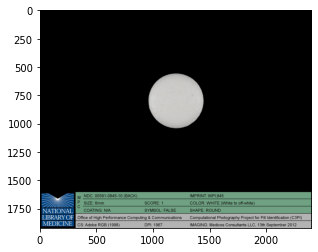

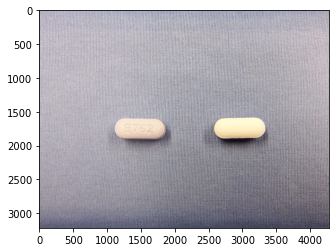

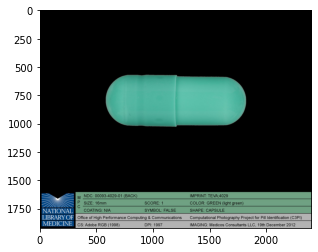

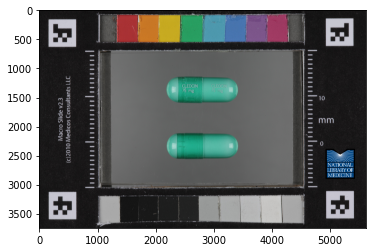

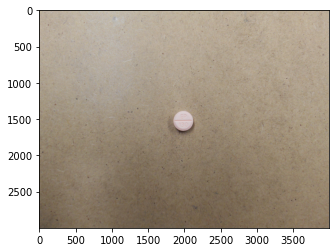

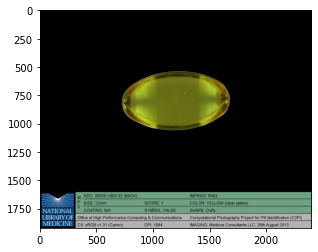

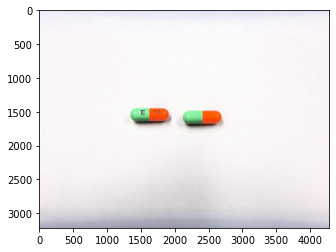

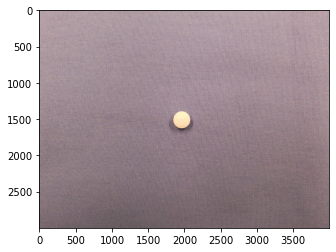

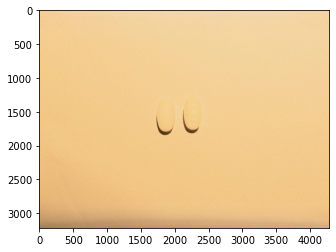

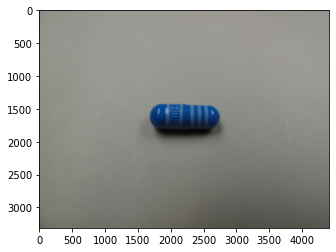

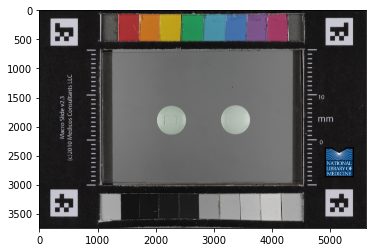

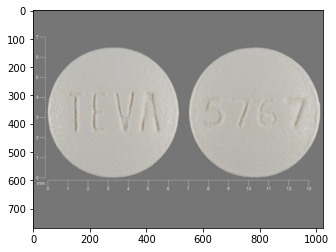

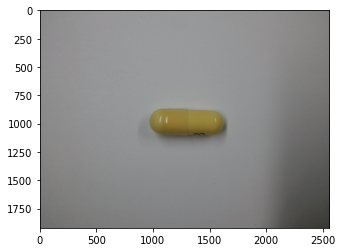

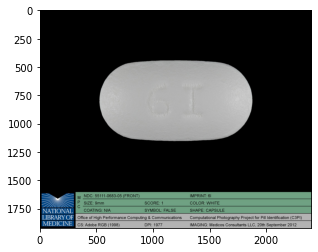

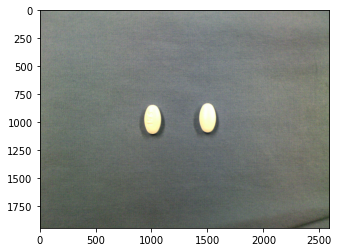

In [0]:
images = os.listdir()
def process(filename):
    if not filename.startswith('.'):
      image = mpimg.imread(filename)
      plt.figure()
      plt.imshow(image)


for file in images:
    process(file)

## Get Train/Test Images

These code blocks are where your dataset will be downloaded to your local directory.





In [0]:
drugsftp = df.FILE.tolist()
drugsftp.sort()
drugsftp[:10] # the list of files you are requesting from the ftp server

['PillProjectDisc1/images/!1ECEZFCQZ5I6S0RP6IZ-T!_6Y2RXW.PNG',
 'PillProjectDisc1/images/!AOKWIRBTDVYLX41JNYGUE1OPO6-15.JPG',
 'PillProjectDisc1/images/!ER_L-9UW4J0KP5FQTJ2-LQKM!FKUK.JPG',
 'PillProjectDisc1/images/!GAGH9SEMPWXKDD0B79O2WDHDYV_3.JPG',
 'PillProjectDisc1/images/!J0N020HAC1N9IDCYU3QJJN!5YA2A!.PNG',
 'PillProjectDisc1/images/!Y7FKLUPG3TK-OZ7A5EVQCVF420-VJ.PNG',
 'PillProjectDisc10/images/6MBF88872OTKN19TLJH!0QLNOED708.JPG',
 'PillProjectDisc10/images/6MN99VY2IAUCLJKPCED_JG-ZAGUAPO.PNG',
 'PillProjectDisc10/images/6R55YN3L0OOT3RFCFHZNUMSETXTC22.JPG',
 'PillProjectDisc10/images/6R66C0USAMBP_!SWRIXWYLZ15G9RL.PNG']

In [0]:
ftpdir = {}
for i in range(0,len(drugsftp)):
    ftpcall = drugsftp[i].split('/') #separate the folder from the file
    ftppath = ftpcall[0]+'/'+ftpcall[1]+ '/'
    ftpfile = ftpcall[-1] #isolate the filename
    ftpdir.setdefault(ftppath,[])
    ftpdir[ftppath].append(ftpfile) #create the folder:file pair
len(ftpdir)

110

In [0]:
%cd /content/drive/My Drive/Project: Pill ID

try:
  os.makedirs('Data/Raw')
except:
  print('Folders present')
try:
  os.makedirs('Data/To_sort')
except:
  print('Folders present')


%cd /content/drive/My Drive/Project: Pill ID/Data/Raw

dloaded = os.listdir()
counter = len(dloaded)
for key in ftpdir.keys():
    ftp = FTP('lhcftp.nlm.nih.gov')
    ftp.login()
    ftp.cwd('Open-Access-Datasets/Pills//')
    ftp.cwd(key)
    #clear_output()
    for value in ftpdir[key]:
      #clear_output(wait=True)
      #print(str(counter) + ' of ' + str(len(drugsftp)) + ' downloaded')
      if value not in dloaded:       
        with open(value, 'wb') as fp:
            ftp.retrbinary('RETR '+ value, fp.write)
            counter += 1
    ftp.cwd('..')
    ftp.cwd('..')
%cd /content/drive/My Drive/Project: Pill ID/Data

/content/drive/My Drive/Project: Pill ID
Folders present
Folders present
/content/drive/My Drive/Project: Pill ID/Data/Raw
/content/drive/My Drive/Project: Pill ID/Data


In [0]:
%cd /content/drive/My Drive/Project: Pill ID/Data

for filename in os.listdir('Raw'):
  if filename.endswith(".PNG") or filename.endswith(".JPG"): 
      try:
        im1 = Image.open(r'Raw/{}'.format(filename))
        rgb_im = im1.convert('RGB')
        rgb_im.save(r'To_sort/{}.JPG'.format(filename[:-4]))
      except:
        print('Could not convert {}'.format(filename))
        df = df[df.FILENAME != filename]
      continue
      
  elif filename.endswith(".CR2") and os.path.getsize('Raw/'+filename) > 0:
      try:
        raw = rawpy.imread('Raw/{}'.format(filename))
        rgb = raw.postprocess()
        imageio.imsave('To_sort/{}.JPG'.format(filename[:-4]), rgb)
      except:
        print('Could not convert {}'.format(filename))
      continue


/content/drive/My Drive/Project: Pill ID/Data
Could not convert UH4E9ZBAEZVA06YAC54HF3JSEO!8DB.JPG


## Sort Images by Class

In [0]:
df['FILENAME'] = df.FILENAME.str[:-4] + '.JPG' #all files are now .JPG in the local directory, updating df to reflect
#df['FILETYPE'] = df.FILENAME.str[-4:] # I don't think this is needed any longer, will confirm
df # our final dataframe we will reference to sort our images

NDC  IDK  ...                             FILENAME FILETYPE
1226    00006074554    1  ...  B7VF6YKZAKU7R6RH9PJC6-Q3QNJYYO4.JPG     .JPG
1227    00006074554    1  ...  BZRBET5WWF01MHM0TS8UAJE_XKVUZV8.JPG     .JPG
1228    00006074554    1  ...   W7_68M2JGM2VVC-5BAJURW0-MELXXR.JPG     .JPG
1229    00006074554    1  ...   ZSLAKUF3PNEZFLJIRVSV6-ZS7V7-QL.JPG     .JPG
1230    00006074554    1  ...   7RPWFG3ZF3E0LL1L!4TBAD7BD_WGWY.JPG     .JPG
...             ...  ...  ...                                  ...      ...
124244  65862019905    1  ...  B48ZJ0_NS_D9U78ON7-GM3UGB26UI1W.JPG     .JPG
124245  65862019905    1  ...  BZ1FSXTOE4T22MSGJXFRTL16HYT8GXR.JPG     .JPG
124246  65862019905    1  ...   1XUYSB3P6Q36KO510FS9BWMK5GW_AQ.JPG     .JPG
124247  65862019905    1  ...  CIHOS-4VFVZT8UTQZ00OYFI-M!HB4OW.JPG     .JPG
124248  65862019905    1  ...   -C9U9YVLUDE71T0KQE16CXA5Z1YA39.JPG     .JPG

[749 rows x 9 columns]

In [0]:
%cd /content/drive/My Drive/Project: Pill ID/Data


try:
  os.makedirs('/content/drive/My Drive/Project: Pill ID/Data/{}/Classes'.format(setname)) #create a directory for this collection of drugs images 
except:
  print('Folder already created')

unclassed = '/content/drive/My Drive/Project: Pill ID/Data/To_sort' #our unclassed images live here, we will refer to this path


for img in os.listdir(unclassed):
  try:
    folder = df.NDC[df.FILENAME == img].tolist()[0] # get the NDC for the drug being iterated
  except:
    print('{} not in df'.format(img)) # in case an errant file made it through, we dont want to add to our sorted directories
  
  try:
    classed = '{}/Classes/{}'.format(setname,folder)
    os.mkdir(classed) # create a folder if it doesnt already exist
  except:
    print('folder_exists...')
  
  try:
    origin = os.path.join(unclassed, img) # find our image in unclassed...
    destination = os.path.join(classed, img) #declare where we want to put it.... 
    shutil.copy(origin, destination) # and copy the file 
  except:
    print('Could not copy file {}'.format(img))

In [0]:
# finally we print our new class directories and their file counts 
for fldr in os.listdir(setname + '/Classes'):
  files = len(os.listdir(setname + '/Classes'+ '/' + fldr))
  print(fldr.title() + ' : ' + str(files))

00591084510 : 50
24486060490 : 50
00093402901 : 50
00009033102 : 50
64125013010 : 50
00555188302 : 50
65862019430 : 50
23155010501 : 50
00781196160 : 50
24090047988 : 49
24486060310 : 50
00093576756 : 50
65862019905 : 50
55111068305 : 50
00006074554 : 50


In [0]:
#shutil.rmtree('Raw') # delete the raw images if desired